# Prepare environment

In [1]:
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip install -U --pre tensorflow=="2.*"
!pip install -U --pre tensorflow-gpu=="1.15"

Requirement already up-to-date: tensorflow-gpu==1.15 in /usr/local/lib/python3.6/dist-packages (1.15.0)


In [0]:
# !pip install -U tensorflow_estimator=="1.15.1"

In [4]:
!pip install pycocotools

In [0]:
# %%bash
# cd /content/gdrive/My\ Drive/object_detection/models/research
# export PYTHONPATH=$PYTHONPATH:pwd:pwd/slim
# protoc object_detection/protos/*.proto --python_out=.
# python setup.py build
# python setup.py install

In [0]:
# !export PYTHONPATH=/content/gdrive/My\ Drive/object_detection/models
# !export PYTHONPATH=/content/gdrive/My\ Drive/object_detection/models/research
# !export PYTHONPATH=/content/gdrive/My\ Drive/object_detection/models/research/slim

In [0]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [0]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

In [10]:
%%bash
cd /content/models/research/slim/ 
python setup.py build
python setup.py install

running build
running build_py
running egg_info
writing slim.egg-info/PKG-INFO
writing dependency_links to slim.egg-info/dependency_links.txt
writing top-level names to slim.egg-info/top_level.txt
writing manifest file 'slim.egg-info/SOURCES.txt'
running install
running bdist_egg
running egg_info
writing slim.egg-info/PKG-INFO
writing dependency_links to slim.egg-info/dependency_links.txt
writing top-level names to slim.egg-info/top_level.txt
writing manifest file 'slim.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/datasets
copying build/lib/datasets/download_and_convert_imagenet.sh -> build/bdist.linux-x86_64/egg/datasets
copying build/lib/datasets/download_and_convert_visualwakewords.py -> build/bdist.linux-x86_64/egg/datasets
copying build/lib/datasets/imagenet_2012_validation_synset_labels.txt -> build/bdist.linux-x86_64/egg/datasets
copyi

zip_safe flag not set; analyzing archive contents...


In [11]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017522 sha256=e852acb78666f4abb4182e938b5fc5700dc6644293f419b1a937fbb313a045a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ziktwoyv/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [12]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [13]:
tf.__version__

'1.15.0'

In [0]:
os.chdir('/content/gdrive/My Drive/object_detection')

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Creating workspace

In [0]:
# try:
#     # os.mkdir('./workspace')
#     # os.mkdir('./workspace/training')
#     os.makedirs('./workspace/training/annotations')
#     os.makedirs('./workspace/training/pre-trained-models')
# except:
#     pass

In [0]:
from pathlib import Path
import pandas as pd
import os
from IPython.display import display


dataset_path = Path("/content/gdrive/My Drive/object_detection/dataset_short")
annot_path = dataset_path/"annotations/train/2018-03-07_1322_right/"

In [19]:
annot_path

PosixPath('/content/gdrive/My Drive/object_detection/dataset_short/annotations/train/2018-03-07_1322_right')

In [25]:
# !python /content/gdrive/My\ Drive/object_detection/workflow/utils/tsv_to_csv.py -i /content/gdrive/My\ Drive/object_detection/dataset_short/annotations/train/2018-03-07_1322_right/ -o /content/gdrive/My\ Drive/object_detection/workflow/training/annotations/train

/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/train/2018-03-07_1322_right
     filename  ...  ymax
0  000121.jpg  ...   972
1  000121.jpg  ...   981
2  000121.jpg  ...   994
3  000121.jpg  ...   968
4  000121.jpg  ...   975

[5 rows x 8 columns]
Successfully converted xml to csv.


In [0]:
# PATH_TO_IMAGES_FOLDER = str(dataset_path/"images/train/2018-03-07_1322_right/")
PATH_TO_IMAGES_FOLDER = str("/content/gdrive/My Drive/object_detection/workflow/training/images/train")

In [28]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf
# import tensorflow.compat.v1 as tf
import sys
sys.path.append("./models/research")

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict


tf.logging.set_verbosity(tf.logging.INFO)

try:
    flags = tf.app.flags

    flags.DEFINE_string('csv_input', '/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/2018-03-07_1322_right.csv', 'Path to the CSV input')
    flags.DEFINE_string('output_path', '/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/2018-03-07_1322_right.record', 'Path to output TFRecord')
    flags.DEFINE_string('label', 'sign', 'Name of class label')
    # if your image has more labels input them as
    # flags.DEFINE_string('label0', '', 'Name of class[0] label')
    # flags.DEFINE_string('label1', '', 'Name of class[1] label')
    # and so on.
    flags.DEFINE_string('img_path', PATH_TO_IMAGES_FOLDER, 'Path to images')
    
except:
    pass
    
FLAGS = flags.FLAGS
# TO-DO replace this with label map
# for multiple labels add more else if statements
def class_text_to_int(row_label):
    if row_label == FLAGS.label:  # 'sign':
        return 1
    # comment upper if statement and uncomment these statements for multiple labelling
    # if row_label == FLAGS.label0:
    #   return 1
    # elif row_label == FLAGS.label1:
    #   return 0
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # check if the image format is matching with your images.
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    w_coef = 0.12254902
    h_coef = 0.0146484375
    for index, row in group.object.iterrows():
        if row['class'] != '0':
            xmins.append(row['xmin']*w_coef / width)
            xmaxs.append(row['xmax']*w_coef / width)
            ymins.append(row['ymin']*h_coef / height)
            ymaxs.append(row['ymax']*h_coef / height)
            classes_text.append(row['class'].encode('utf8'))
            classes.append(class_text_to_int(row['class']))
            
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(os.getcwd(), FLAGS.img_path)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))

tf.app.run()

Successfully created the TFRecords: /content/gdrive/My Drive/object_detection/workflow/training/annotations/train/2018-03-07_1322_right.record


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Prepare data and config

In [0]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)
    print(model_dir)
    model_dir = pathlib.Path(model_dir)/"saved_model"
    #   model = tf.saved_model.load(str(model_dir))
    model = tf.compat.v2.saved_model.load(str(model_dir), None)
    model = model.signatures['serving_default']

    # tf.compat.v2.saved_model.save(model, "/content/workspace/training/pre-trained-models/", None)

    return model

In [0]:
with open('/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/road_signs_map.pbtxt', 'w') as f:
    f.write("item {\
                name: \"sign\" \
                id: 1 \
                display_name: \"sign\" \
            }")

In [0]:
# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
PATH_TO_LABELS = '/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/road_signs_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [32]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path(dataset_path/"images/train/2018-03-16_1316_left")
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS[:5]

[PosixPath('/content/gdrive/My Drive/object_detection/dataset_short/images/train/2018-03-16_1316_left/000014.jpg'),
 PosixPath('/content/gdrive/My Drive/object_detection/dataset_short/images/train/2018-03-16_1316_left/000044.jpg'),
 PosixPath('/content/gdrive/My Drive/object_detection/dataset_short/images/train/2018-03-16_1316_left/000072.jpg'),
 PosixPath('/content/gdrive/My Drive/object_detection/dataset_short/images/train/2018-03-16_1316_left/000104.jpg'),
 PosixPath('/content/gdrive/My Drive/object_detection/dataset_short/images/train/2018-03-16_1316_left/000136.jpg')]

# Detection

In [33]:
model_name = 'ssd_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)

/root/.keras/datasets/ssd_inception_v2_coco_2018_01_28
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0317 11:12:04.071547 140455186401152 saver.py:1503] Saver not created because there are no variables in the graph to restore


In [34]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(?, ?, ?, 3) dtype=uint8>]


In [35]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [36]:
detection_model.output_shapes

{'detection_boxes': TensorShape([Dimension(None), Dimension(100), Dimension(4)]),
 'detection_classes': TensorShape([Dimension(None), Dimension(100)]),
 'detection_scores': TensorShape([Dimension(None), Dimension(100)]),
 'num_detections': TensorShape([Dimension(None)])}

In [0]:
# /content/gdrive/My Drive/dataset_short/configs/ssd_inception_v2_coco.config

In [38]:
!python /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir=/content/gdrive/My\ Drive/object_detection/workflow/training/ --pipeline_config_path=/content/gdrive/My\ Drive/object_detection/workflow/training/configs/ssd_inception_v2_coco.config

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Use object_detection/model_main.py.
W0317 11:12:15.631687 140448745506688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.

W0317 11:12:15.632016 140448745506688 module_wrapper.py:139] From /content/models/research/object_detection/legacy/train.py:91: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0317 11:12:15.632999 140448745506688 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-pa

# Tensorfboard visualization

In [0]:
%%bash
cd /content
wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = '/content/gdrive/My\ Drive/object_detection/workflow/training'
get_ipython().system_raw(
    'tensorboard --logdir={} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [42]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


# Inference

In [0]:
try:
    os.makedirs('/content/gdrive/My Drive/object_detection/workflow/training/trained_inference_graphs')
except:
    pass

# with open('/content/gdrive/My Drive/object_detection/workflow/training/trained_inference_graphs/output_inference_graph_v1.pb', 'w') as f:
#     f.write('')

In [62]:
%%bash
cd /content/gdrive/My\ Drive/object_detection/workflow/training
python /content/models/research/object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path /content/gdrive/My\ Drive/object_detection/workflow/training/configs/ssd_inception_v2_coco.config --trained_checkpoint_prefix /content/gdrive/My\ Drive/object_detection/workflow/training/model.ckpt-0 --output_directory /content/gdrive/My\ Drive/object_detection/workflow/training/trained_inference_graphs

Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in the Variable).

Profile:
node

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0317 11:17:10.039064 140213636102016 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0317 11:17:10.048686 140213636102016 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0317 11:17:10.049326 140213636102016 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.

In [0]:
class SignClassifier(object):
    def __init__(self):
        PATH_TO_MODEL = '/content/gdrive/My Drive/object_detection/workflow/training/trained_inference_graphs/frozen_inference_graph.pb'
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            # Works up to here.
            with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)

    def get_classification(self, img):
    # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            img_expanded = np.expand_dims(img, axis=0)  
            (boxes, scores, classes, num) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_expanded})
        return boxes, scores, classes, num

In [0]:
import cv2
from google.colab.patches import cv2_imshow


def draw_boxes(img, boxes):
    w_coef = 1*0.12254902
    h_coef = 1*0.0146484375

    for xmin, ymin, xmax, ymax in boxes[0]:
        start_point = tuple([int(xmin*2448*w_coef), int(ymin*2048*h_coef)])
        end_point = tuple([int(xmax*2448*w_coef), int(ymax*2048*h_coef)])
        cv2.rectangle(img, start_point, end_point, 255, 4)

    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)

In [66]:
img = Image.open('/content/gdrive/My Drive/object_detection/workflow/training/images/train/000093.jpg')
img = np.uint8(img)
print(img.shape)

boxes, scores, classes, num = SignClassifier().get_classification(img)
boxes.shape

(300, 300, 3)


(1, 5, 4)

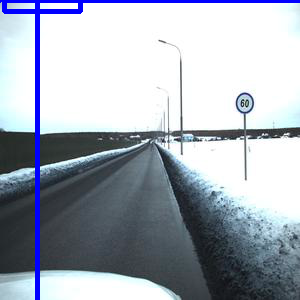

In [71]:
draw_boxes(img, boxes)

In [68]:
boxes

array([[[0.01525554, 0.        , 0.26951852, 0.3782488 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]], dtype=float32)

In [0]:
# input_path: "/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/2018-03-07_1322_right.record"

# label_map_path: "/content/gdrive/My Drive/object_detection/workflow/training/annotations/train/road_signs_map.pbtxt"